<a href="https://colab.research.google.com/github/kwojtylko/flat_price_estimator/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# import bibliotek
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import collections

In [64]:
# wczytywanie danych
gratka_df = pd.read_csv("gratka_dane_model.csv")
gratka_df

,url_base,url_page,page,location,title,link,description,area_m2,n_rooms,n_floor,price_per_m2,district
0,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,44.93,2,7.0,10700,Krowodrza
1,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Podgórze, ul. Golikówka",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Kukla Nieruchomości prezentujeMieszkanie 2- po...,42.00,2,1.0,7024,Podgórze
2,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,59.15,3,1.0,9400,Krowodrza
3,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,50.56,2,7.0,10300,Krowodrza
4,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,1,"Kraków, ...","Nowe mieszkanie Kraków Krowodrza, ul. Pod Fortem",https://gratka.pl/nieruchomosci/nowe-mieszkani...,Poznajcie bliżej naszą inwestycję – Krowodrza ...,76.35,4,6.0,9700,Krowodrza
...,...,...,...,...,...,...,...,...,...,...,...,...
3476,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,42.22,2,0.0,9995,Płaszów
3477,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,67.07,3,1.0,8916,Płaszów
3478,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,63.05,3,1.0,9056,Płaszów
3479,https://gratka.pl/nieruchomosci/mieszkania/kra...,https://gratka.pl/nieruchomosci/mieszkania/kra...,110,"Kraków, ...","Nowe mieszkanie Kraków Płaszów, ul. Myśliwska",https://gratka.pl/nieruchomosci/nowe-mieszkani...,W budynkach Myśliwska Solar Garden w Krakowie-...,62.59,3,0.0,9394,Płaszów


In [65]:
#zdefiniownie cech do modelu
model_col = ["area_m2", "n_rooms", "n_floor", "district", "price_per_m2"]
model_df = gratka_df[model_col]
model_df

,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


In [66]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3481 entries, 0 to 3480
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_m2       3481 non-null   float64
 1   n_rooms       3481 non-null   int64  
 2   n_floor       3481 non-null   float64
 3   district      2918 non-null   object 
 4   price_per_m2  3481 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 136.1+ KB


In [67]:
model_df.describe()

,area_m2,n_rooms,n_floor,price_per_m2
count,3481.000000,3481.000000,3481.000000,3481.000000
mean,55.448914,2.559609,2.392129,10631.935363
std,26.350922,1.027479,2.197552,2941.337028
min,13.300000,1.000000,0.000000,4999.000000
25%,39.000000,2.000000,1.000000,8893.000000
50%,51.080000,3.000000,2.000000,9940.000000
75%,66.110000,3.000000,4.000000,11955.000000
max,230.000000,6.000000,14.000000,40000.000000


In [68]:
#sprawdzenie braków w danych
model_df.isna().sum()

area_m2           0
n_rooms           0
n_floor           0
district        563
price_per_m2      0
dtype: int64

In [69]:
#uzupełnianie braków
model_df["district"].fillna("brak", inplace=True)
model_df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



area_m2         0
n_rooms         0
n_floor         0
district        0
price_per_m2    0
dtype: int64

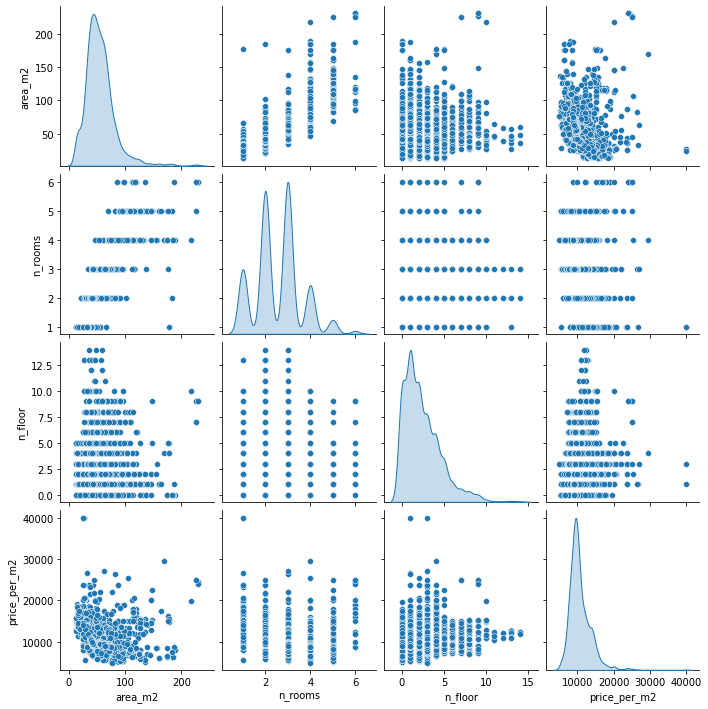

In [70]:
# wykres zależności między cechami
sns.pairplot(model_df, diag_kind="kde");

In [71]:
px.box(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia", orientation = "h")

In [72]:
px.box(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi", orientation = "h")

In [73]:
px.box(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra", orientation = "h")

In [74]:
px.box(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena", orientation = "h")

In [75]:
px.scatter(model_df, x = "price_per_m2", title = "Rozrzut cechy - cena")

In [76]:
px.scatter(model_df, x = "area_m2", title = "Rozrzut cechy - powierzchnia")

In [77]:
px.scatter(model_df, x = "n_rooms", title = "Rozrzut cechy - liczba pokoi")

In [78]:
px.scatter(model_df, x = "n_floor", title = "Rozrzut cechy - nr piętra")

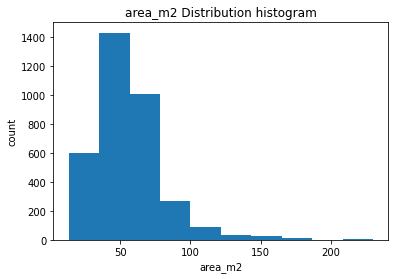

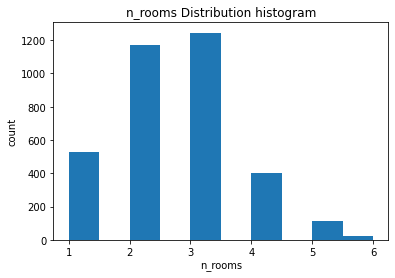

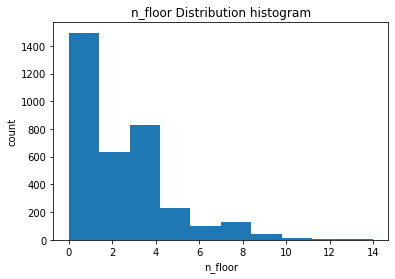

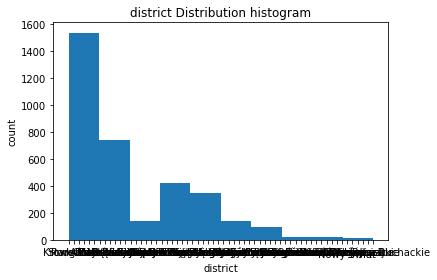

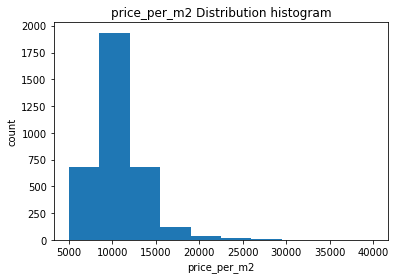

In [79]:
#data distribution - list of histograms

for column in model_df.columns:
  plt.hist(column, data = model_df)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

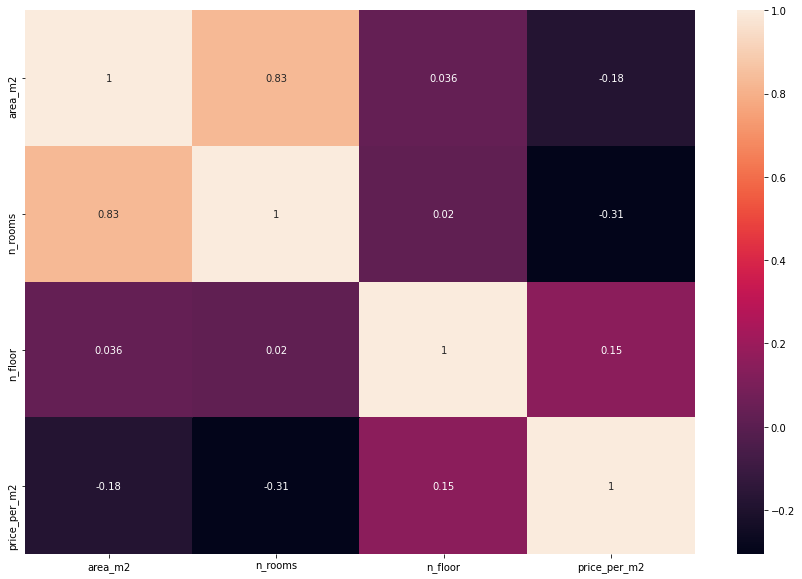

In [80]:
plt.figure(figsize=(15, 10))
corr=model_df.corr()
sns.heatmap(corr,annot=True);

##Wartości odstające

###Powierzchnia

In [81]:
# tworzenie funkcji do identyfikacji anomalii (Q1~10%, Q3~90%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [10, 90])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df["flaga_IQR"] = IQR_outliers(model_df["area_m2"])
print(model_df["flaga_IQR"])

# wizualizacja wartości odstających wg. powierzchni
px.scatter(model_df, 
           x = "price_per_m2", 
           y = "area_m2",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - powierzchnia (area_m2) a wartości odstające")

Górne ograniczenie: 164.20999999999998
Dolne ograniczenie: -51.629999999999995
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3481, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [82]:
# usuwanie obserwacji odstajacych wg. powierzchni
model_df_2 = model_df[model_df["flaga_IQR"]==1]
model_df_2.shape

(3454, 6)

### Liczba pokoi

In [83]:
# tworzenie funkcji do identyfikacji anomalii (Q1~20%, Q3~80%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [20, 80])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (2.0 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_2["flaga_IQR"] = IQR_outliers(model_df_2["n_rooms"])
print(model_df_2["flaga_IQR"])

# wizualizacja wartości odstających wg. liczby pokoi
px.scatter(model_df_2, 
           x = "price_per_m2", 
           y = "n_rooms",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - liczba pokoi (n_rooms) a wartości odstające")

Górne ograniczenie: 5.0
Dolne ograniczenie: 0.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3454, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [84]:
# usuwanie obserwacji odstajacych wg. liczby pokoi
model_df_3 = model_df_2[model_df_2["flaga_IQR"]==1]
model_df_3.shape

(3439, 6)

###Numer piętra

In [85]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [25, 75])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_3["flaga_IQR"] = IQR_outliers(model_df_3["n_floor"])
print(model_df_3["flaga_IQR"])

# wizualizacja wartości odstających wg. nr piętra
px.scatter(model_df_3, 
           x = "price_per_m2", 
           y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - numer piętra (n_floor) a wartości odstające")

Górne ograniczenie: 8.5
Dolne ograniczenie: -3.5
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3439, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [86]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_4 = model_df_3[model_df_3["flaga_IQR"]==1]
model_df_4.shape

(3378, 6)

###Cena

In [87]:
# tworzenie funkcji do identyfikacji anomalii (Q1~25%, Q3~75%)
def IQR_outliers(a):
  Q1, Q3 = np.percentile(a, [20, 80])
  IQR = Q3 - Q1

  gorne_ograniczenie  = Q3 + (1.5 * IQR)
  dolne_ograniczenie  = Q1 - (1.5 * IQR)
  print("Górne ograniczenie:", gorne_ograniczenie)
  print("Dolne ograniczenie:", dolne_ograniczenie)

  indeksy = np.where((a > gorne_ograniczenie) | (a < dolne_ograniczenie))
  b = np.full(shape=a.shape[0], fill_value=1)
  b[indeksy] = -1
  
  return b

# użycie funkcji
model_df_4["flaga_IQR"] = IQR_outliers(model_df_4["price_per_m2"])
print(model_df_4["flaga_IQR"])

# wizualizacja wartości odstających wg. ceny 1 m2 mieszkania
px.scatter(model_df_4, 
           x = "price_per_m2", 
           #y = "n_floor",
           hover_name = "district",
           color = "flaga_IQR", 
           title = "Rozrzut cechy - cena (price_per_m2) a wartości odstające")

Górne ograniczenie: 18500.0
Dolne ograniczenie: 2500.0
0       1
1       1
2       1
3       1
4       1
       ..
3476    1
3477    1
3478    1
3479    1
3480    1
Name: flaga_IQR, Length: 3378, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
# usuwanie obserwacji odstajacych wg. numeru piętra
model_df_5 = model_df_4[model_df_4["flaga_IQR"]==1]
model_df_5.shape

(3327, 6)

In [89]:
# oblicznie % usuniętych obserwacji
print("% usuniętych obserwacji odstających: ", ((model_df.shape[0]-model_df_5.shape[0])/model_df.shape[0])*100)

% usuniętych obserwacji odstających:  4.424016087331227


In [90]:
# usuwanie nieużuwanej cechy - flaga_IQR
model_df_5.drop(columns = ["flaga_IQR"], inplace = True)
model_df_5

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,area_m2,n_rooms,n_floor,district,price_per_m2
0,44.93,2,7.0,Krowodrza,10700
1,42.00,2,1.0,Podgórze,7024
2,59.15,3,1.0,Krowodrza,9400
3,50.56,2,7.0,Krowodrza,10300
4,76.35,4,6.0,Krowodrza,9700
...,...,...,...,...,...
3476,42.22,2,0.0,Płaszów,9995
3477,67.07,3,1.0,Płaszów,8916
3478,63.05,3,1.0,Płaszów,9056
3479,62.59,3,0.0,Płaszów,9394


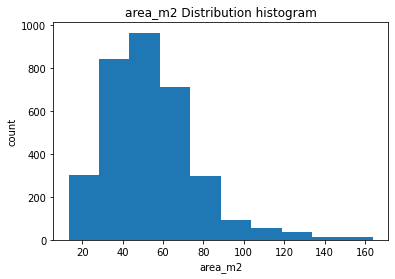

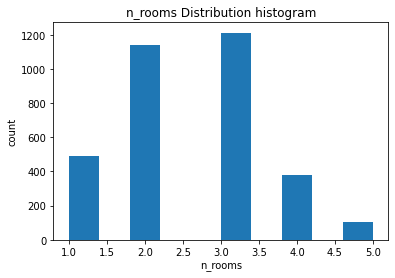

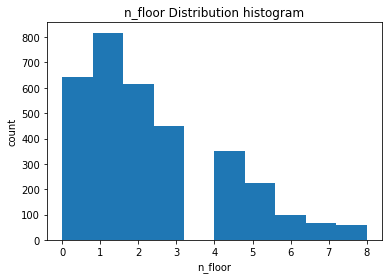

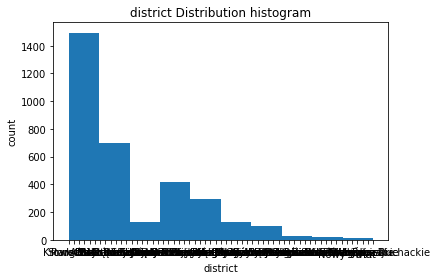

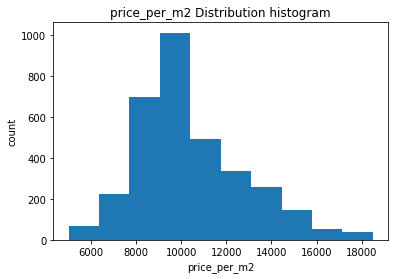

In [91]:
#data distribution - list of histograms

for column in model_df_5.columns:
  plt.hist(column, data = model_df_5)
  plt.title(label = column + ' Distribution histogram')
  plt.ylabel(ylabel = 'count')
  plt.xlabel(xlabel= column)
  plt.show()

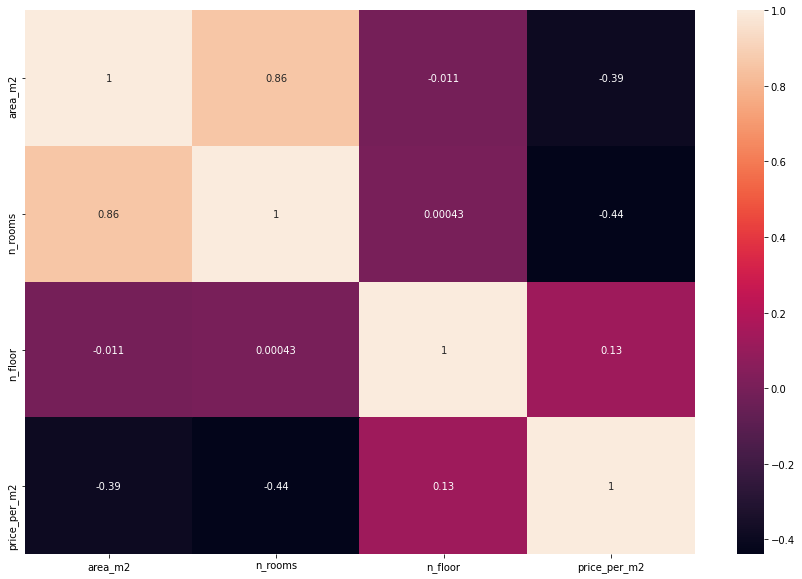

In [92]:
plt.figure(figsize=(15, 10))
corr=model_df_5.corr()
sns.heatmap(corr,annot=True);

##Zmienne kategoryczne

### Dzielnica

In [93]:
model_df_5["district"].value_counts()

brak                      552
Podgórze                  375
Mistrzejowice             280
Płaszów                   280
Prądnik Biały             275
Grzegórzki                223
Krowodrza                 209
Zabłocie                  156
Wola Duchacka             108
Os. Prądnik Biały          92
Bieżanów                   83
Dębniki                    72
Prądnik Czerwony           57
Stare Miasto               53
Górka Narodowa             42
Nowa Huta                  40
Wola Justowska             40
Bronowice Małe             31
Czyżyny Stare              29
Salwator                   29
Czyżyny                    25
Azory                      25
Os. Prądnik Czerwony       24
Os. Kliny Zacisze          20
Bronowice                  18
Os. Ruczaj                 18
Olsza                      16
Podgórze Stare             14
Dąbie                      13
Zwierzyniec                12
Os. Złocień                11
Sidzina                    11
Kazimierz                   8
Kurdwanów 

In [95]:
# kodowanie kategorii 
model_df_6 = pd.get_dummies(model_df_5, columns=["district"], prefix_sep="_")
model_df_6

,area_m2,n_rooms,n_floor,price_per_m2,district_Azory,district_Bielany,district_Bieżanów,district_Borek Fałęcki,district_Bronowice,district_Bronowice Małe,district_Bronowice Wielkie,district_Cichy Kącik,district_Czyżyny,district_Czyżyny Stare,district_Dąbie,district_Dębniki,district_Grzegórzki,district_Grzegórzki Stare,district_Górka Narodowa,district_Kazimierz,district_Kleparz,district_Krowodrza,district_Kurdwanów,district_Ludwinów,district_Mateczny,district_Mistrzejowice,district_Nowa Huta,district_Nowa Wieś,district_Nowy Świat,district_Olsza,district_Olszanica,district_Opatkowice,district_Os. Bieżanów Nowy,district_Os. Kliny Zacisze,district_Os. Mistrzejowice Nowe,district_Os. Prądnik Biały,district_Os. Prądnik Czerwony,district_Os. Ruczaj,district_Os. Złocień,district_Podgórze,district_Podgórze Stare,district_Prądnik Biały,district_Prądnik Czerwony,district_Pychowice,district_Półwsie Zwierzynieckie,district_Płaszów,district_Ruczaj,district_Salwator,district_Sidzina,district_Stare Miasto,district_Swoszowice,district_Tonie,district_Ugorek,district_Warszawskie,district_Witkowice,district_Wola Duchacka,district_Wola Justowska,district_XI Podgórze Duchackie,district_Zabłocie,district_Zwierzyniec,district_brak,district_Łagiewniki,district_Łobzów
0,44.93,2,7.0,10700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,42.00,2,1.0,7024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,59.15,3,1.0,9400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50.56,2,7.0,10300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,76.35,4,6.0,9700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3476,42.22,2,0.0,9995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3477,67.07,3,1.0,8916,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3478,63.05,3,1.0,9056,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3479,62.59,3,0.0,9394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Sprawdzanie korelacji


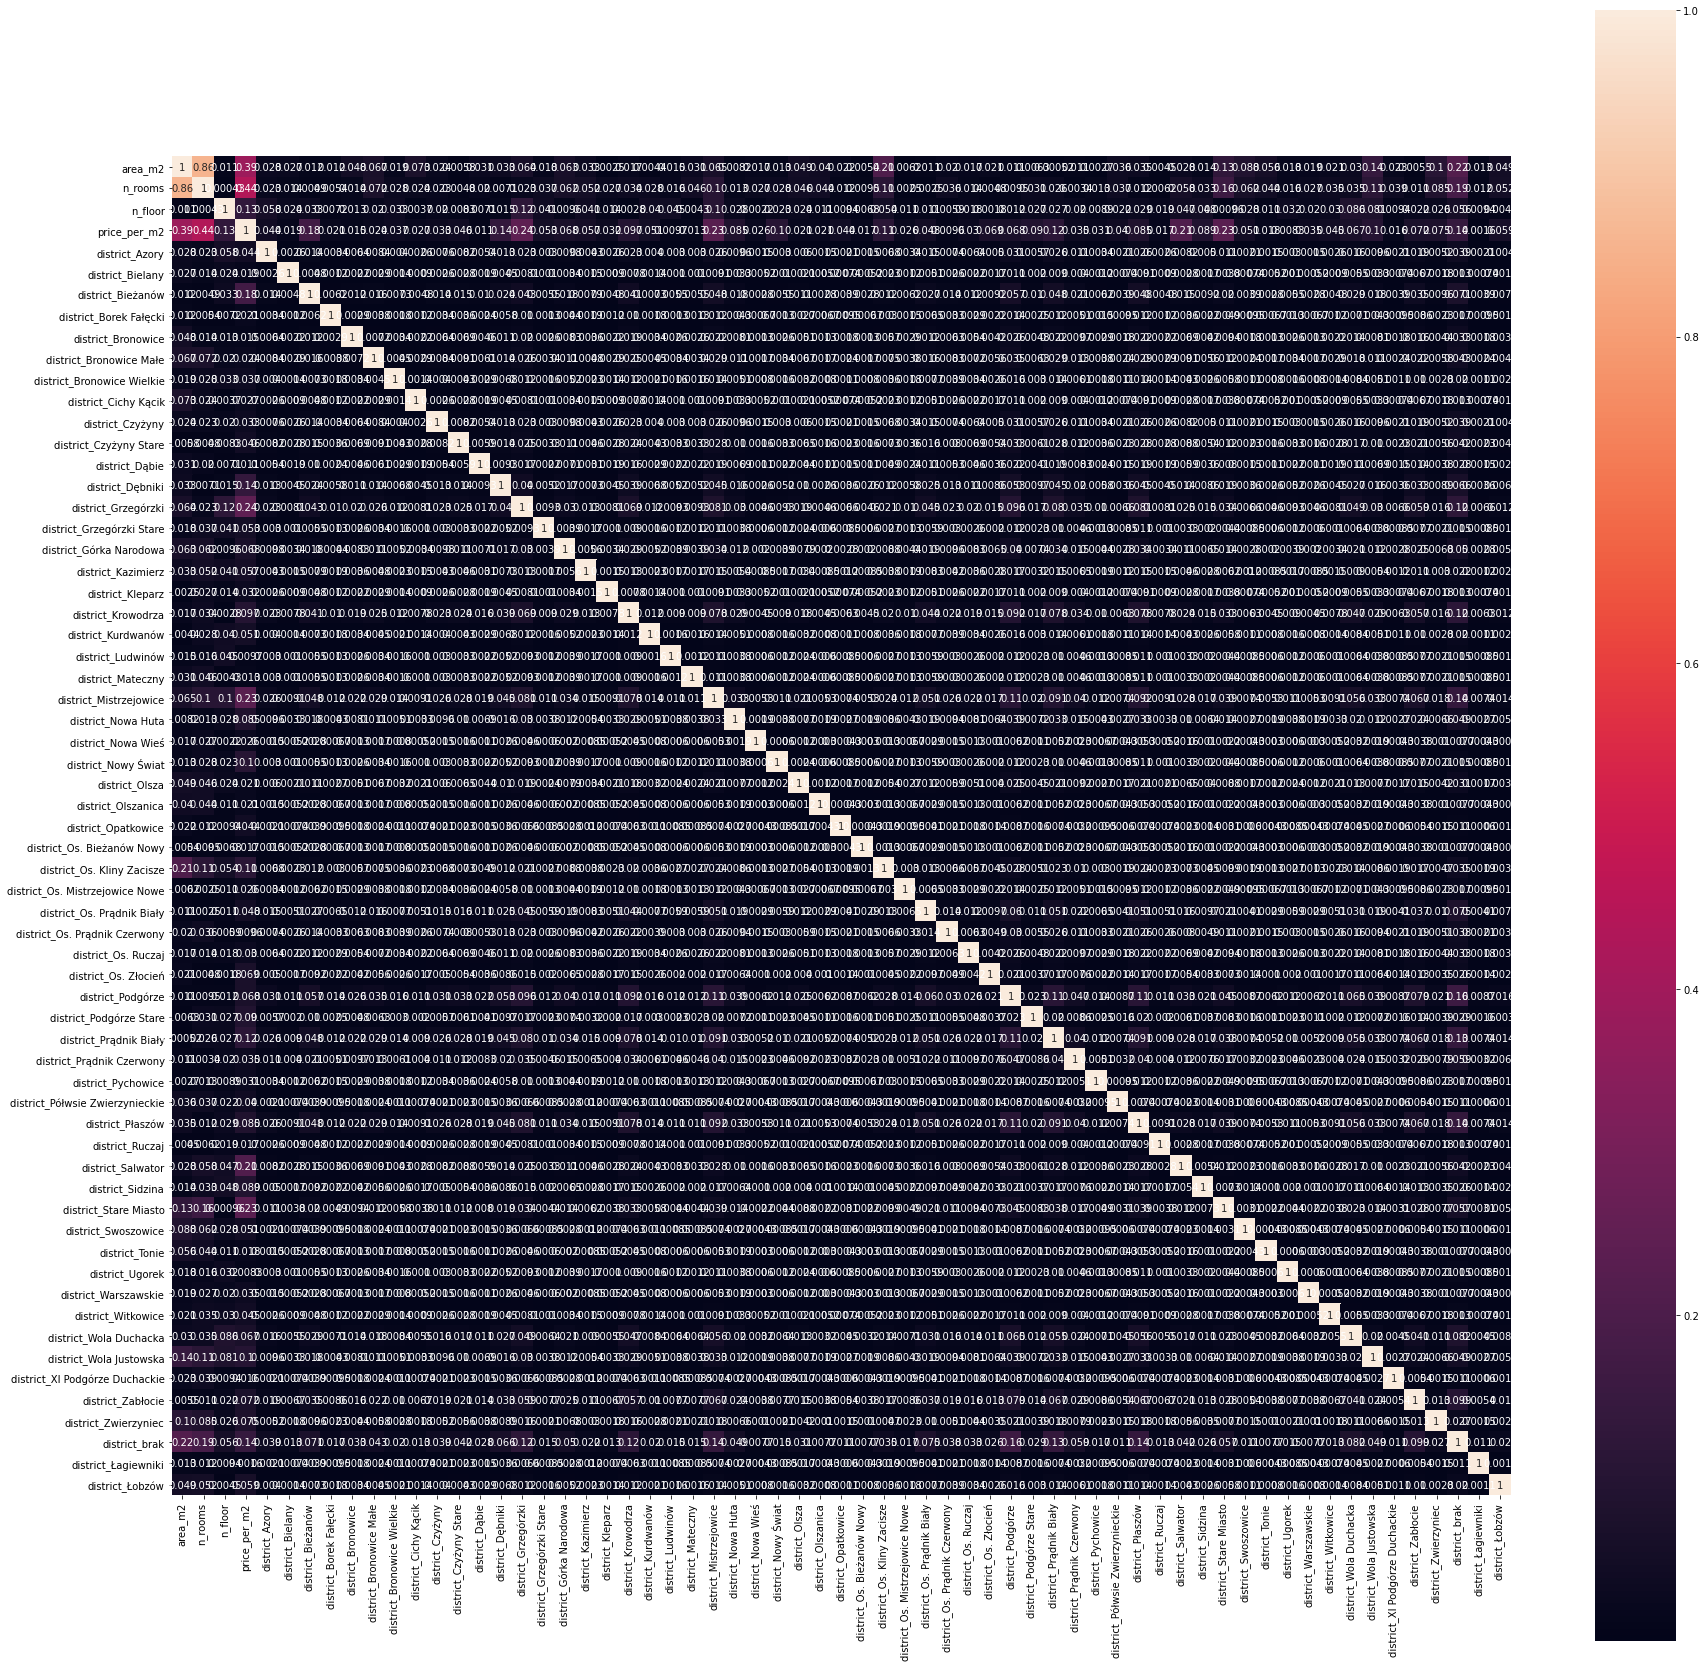

In [97]:
plt.figure(figsize = (30, 30))
corr = model_df_6.corr().abs()
sns.heatmap(corr, square = True, annot = True);

In [101]:
# zdefiniowanie macierzy do filtrowania
macierz_filter = np.triu(np.ones(corr.shape), k=1).astype(np.bool)

# wybranie górnej części trójkąta w macierzy korelacji
gorny_trojkat = corr.where(macierz_filter)

# zdefiniowanie indeksów kolumn o korelacji powyżej 0.9
indeks_mocna_korelacja = [kolumna for kolumna in gorny_trojkat.columns if any(gorny_trojkat[kolumna] > 0.9)]
print(indeks_mocna_korelacja)
# brak mocnej  korelacji w danych

[]
